In [23]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import copy
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from unidecode import unidecode
import spacy
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, f1_score, hamming_loss
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)

In [24]:
file = pd.read_excel(r"D:\기업 프로젝트\딜리버리엠\데이터바우처 납품 DB_240807_1336.xlsx")

print(file.shape)
print(file.columns)
file.head()

(4727, 16)
Index(['Reference', 'Country', 'Buyer', 'Classification', 'Website', 'Email',
       'Telephone No.', 'Segment1', 'Segment2', 'Segment3', 'Item', 'Note',
       'Contact', 'Mobile', '열1', 'Unnamed: 15'],
      dtype='object')


,Reference,Country,Buyer,Classification,Website,Email,Telephone No.,Segment1,Segment2,Segment3,Item,Note,Contact,Mobile,열1,Unnamed: 15
0,"중고 레이저, ESTHETIC, LASER, 메타소닉, MEDIHUB",USA,Cosmetic Lasers Only,NaN,https://cosmeticlasersonly.com/,https://cosmeticlasersonly.com/,1 (866) 575-9948,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,"ALMA, CUTERA, CYNERON, LUMENIS",NaN,NaN,NaN,NaN,NaN
1,NaN,COLOMBIA,(AFTER INKED COLOMBIA) SAS,NaN,https://www.afterinkedcolombia.com/,info@afterinkedcolombia.com,"CEL: + (57) 3112784715, 3125228701",AESTHETIC,DERMATOLOGY,"MATERIAL, COSMETICS",TATOO CREAM,NaN,NaN,NaN,NaN,NaN
2,DERMAPHARMA,Ethiopia,(Badreg Pvt. Ltd. Co)(Mohammed Badrej),NaN,NaN,mohajaberty1980@gmail.com,Tel: +251111264015 / +251111264031 / +25191120...,"MEDICAL, AESTHETIC",DERMATOLOGY,"SKINCARE, COSMECEUTICAL, COSMETIC","DERMAL CREAM, GEL",NaN,NaN,NaN,NaN,NaN
3,DERMAPHARMA,Algeria,(Kalos Beauty And Youth)(Atef Al-Ali),NaN,NaN,ammoon11@gmail.com,Tel: +21323215756 / +21356001008,"MEDICAL, AESTHETIC",DERMATOLOGY,"SKINCARE, COSMECEUTICAL, COSMETIC","DERMAL CREAM, GEL",NaN,NaN,NaN,NaN,NaN
4,메디팜소프트,PERU,A JAIME ROJAS REPRESENTACIONES GRLES S A,NaN,https://www.ajaimerojas.com.pe/,ventas@ajaimerojas.com atencionalcliente@ajaim...,(+51) 995-965-204,"MEDICAL, HOSPITAL","neurosurgery, urology, sterilization, OBGYN, e...","EQUIPMENT, MACHINE, INSTRUMENT, DEVICE, MATERI...","CAPNOGRAPH, MONITOR, defibrillator, STERILIZAT...",NaN,NaN,NaN,NaN,NaN


### A. Delivery M이 공유한 1,282개 데이터

In [25]:
data = file[['Buyer', 'Segment1', 'Segment2', 'Segment3', 'Item']]
data = data.map(lambda x: unidecode(x) if isinstance(x, str) else x)
data.dropna(inplace=True)

data.loc[:, 'Item'] = data['Item'].str.replace(r'\n', ', ', flags=re.IGNORECASE, regex=True)
data.loc[:, 'Segment1'] = data['Segment1'].str.replace(r'\n', ', ', flags=re.IGNORECASE, regex=True)
data.loc[:, 'Segment2'] = data['Segment2'].str.replace(r'\n', ', ', flags=re.IGNORECASE, regex=True)
data.loc[:, 'Segment3'] = data['Segment3'].str.replace(r'\n', ', ', flags=re.IGNORECASE, regex=True)

data

,Buyer,Segment1,Segment2,Segment3,Item
0,Cosmetic Lasers Only,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,"ALMA, CUTERA, CYNERON, LUMENIS"
1,(AFTER INKED COLOMBIA) SAS,AESTHETIC,DERMATOLOGY,"MATERIAL, COSMETICS",TATOO CREAM
2,(Badreg Pvt. Ltd. Co)(Mohammed Badrej),"MEDICAL, AESTHETIC",DERMATOLOGY,"SKINCARE, COSMECEUTICAL, COSMETIC","DERMAL CREAM, GEL"
3,(Kalos Beauty And Youth)(Atef Al-Ali),"MEDICAL, AESTHETIC",DERMATOLOGY,"SKINCARE, COSMECEUTICAL, COSMETIC","DERMAL CREAM, GEL"
4,A JAIME ROJAS REPRESENTACIONES GRLES S A,"MEDICAL, HOSPITAL","neurosurgery, urology, sterilization, OBGYN, e...","EQUIPMENT, MACHINE, INSTRUMENT, DEVICE, MATERI...","CAPNOGRAPH, MONITOR, defibrillator, STERILIZAT..."
...,...,...,...,...,...
4602,VITA NEEDLE COMPANY,MEDICAL,HOSPITAL,CONSUMABLES,"SMALL DIAMETER TUBING, CUSTOM FABRICATED PARTS..."
4606,WINMED,MEDICAL,HOSPITAL,EQUIPMENT,"Liposuction, LASER, TATTO REMOVAL, FACIAL BLUS..."
4612,Winnergy Medical Public Company Limited,MEDICAL,"OBGYN, DIAGNOSTIC, INFECTION","EQUIPMENT, INSTRUMENT, MATERIAL",WINMED's Women Healthcare business unit is com...
4627,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES","ELECTRODE, ELECTROSURGICAL PENCIL, NEEDLE"


### A의 문제점: Item에 문장과 단어가 혼합

In [26]:
data.Item.tolist()

['ALMA, CUTERA, CYNERON, LUMENIS',
 'TATOO CREAM',
 'DERMAL CREAM, GEL',
 'DERMAL CREAM, GEL',
 'CAPNOGRAPH, MONITOR, defibrillator, STERILIZATION AND WASTE TREATMENT CENTER, AUTOCLAVES, CONTAINERS FOR STERILIZATION, BAG CUTTER, LOW TEMPERATURE STERILIZER, See all >, LAPAROSCOPIC SURGERY, CUTTING-MILLING MACHINES FOR TRAUMATOLOGICAL ORTHOPEDIC SURGERY, LASER FOR SURGERY, SURGERY VIDEO TOWERS, See all >, EXTERNAL CONSULTANTS, ANOSCOPES, BALANCES, DIAGNOSTIC CENTER, DERMATOSCOPES, See all >, COVID_19, SECRETION Aspirators, INFUSION PUMPS, OXYGEN CYLINDERS, DEFIBRILLATORS, See all >, INTENSIVE CARE, WALL VACUUM CLEANERS, SECRETION Aspirators, INFUSION PUMPS, ELECTRIC CLINICAL BEDS, See all >, ENDOSCOPY, ENDOTHERAPY, ECO_ENDOSCOPY VIDEO TOWER, DUODENOSCOPE VIDEO, VIDEO ENDOCOSPIES, See all >, OBSTETRICS GYNECOLOGY, RADIANT HEAT CRADLES, DETECTORS, SONOGRAPHER, ELECTROCAUTERS, See all >, CLINICAL LABORATORY, AGITATORS, AUTOCLAVES, PRECISION AND ANALYTICAL BALANCES, MARIE BATHS, See all >, N

### B. A의 문제 해결: Item이 문장으로 된 행 제거 후 남은 395개 데이터

In [27]:
data = data[~data['Item'].str.contains(r'\.|such as|See all|This |which |These |They |Their | is | are |PROVIDES |in providing|PROVIDES A|specializes in', flags=re.IGNORECASE, na=False)] # 'Item', 'Segment1', 'Segment2', 'Segment3'
data = data.map(lambda x: x.upper() if isinstance(x, str) else x) # 모든 열 대문자로
data = data.apply(lambda col: col.str.strip()) # 좌우 공백 제거
data.reset_index(drop=True, inplace=True)
data.Item.tolist()

['ALMA, CUTERA, CYNERON, LUMENIS',
 'TATOO CREAM',
 'DERMAL CREAM, GEL',
 'DERMAL CREAM, GEL',
 'GLOVE, BAG, APRON, MEDICAL PACKAGING SUPPLIES',
 'WHEELCHAIR, LIGHT, XRAY',
 'MEDICAL GAS SYSTEMS, WASTEWATER TREATMENT SYSTEMS, WASTE INCINERATORS, AND SALT PROCESSING EQUIPMENT, LIGHT, MONITER, BED, COMPRESSOR, VACCUUM, OXYGEN, LIGHT, SUCTION',
 'PAEDIATRIC BED',
 'CONSUMABLE',
 'EQUIPMENT, CONSUMABLE',
 'MEDICAL GAS SUPPLIER, VACCUM, OXYGEN, AIR',
 'CLINICAL MEDICATIONS & SUPPLIES, BIOLOGICS, PPE PRODUCTS, SEASONAL RX SPECIALS, CLINICAL DISPOSABLES, DIAGNOSTIC LENSES, ELECTROLYSIS, KITS, OVER THE COUNTER PHARMACEUTICALS, PHARMACEUTICALS, REUSABLE CLINICAL SUPPLIES EYE SURGICAL INSTRUMENTS & SUPPLIES, BIPOLAR INSTRUMENTS, CALIPERS, CANNULAS & CYSTOTOMES, CAPSULE POLISHERS, CHALAZION INSTRUMENTS, CLEANING & STERILIZING, CRYO UNITS, DSEK INSTRUMENTS, FIXATION RINGS & PICKS, FORCEPS & CLAMPS, HOOKS & RETRACTORS, I/A & BIMANUAL HANDPIECES, INSTRUMENT COVERS, KNIFE HANDLES, LACHRYMAL INSTRUMEN

In [28]:
data

,Buyer,Segment1,Segment2,Segment3,Item
0,COSMETIC LASERS ONLY,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,"ALMA, CUTERA, CYNERON, LUMENIS"
1,(AFTER INKED COLOMBIA) SAS,AESTHETIC,DERMATOLOGY,"MATERIAL, COSMETICS",TATOO CREAM
2,(BADREG PVT. LTD. CO)(MOHAMMED BADREJ),"MEDICAL, AESTHETIC",DERMATOLOGY,"SKINCARE, COSMECEUTICAL, COSMETIC","DERMAL CREAM, GEL"
3,(KALOS BEAUTY AND YOUTH)(ATEF AL-ALI),"MEDICAL, AESTHETIC",DERMATOLOGY,"SKINCARE, COSMECEUTICAL, COSMETIC","DERMAL CREAM, GEL"
4,A PACK DISTRIBUTION LTD,MEDICAL,GENERAL,CONSUMABLES,"GLOVE, BAG, APRON, MEDICAL PACKAGING SUPPLIES"
...,...,...,...,...,...
390,"VICTORY EIGHT ENTERPRISE CO.,LTD",MEDICAL,DERMATOLOGY,MACHINE,"PIGMENT LASER, RF, HIFU, IPL, LLLT, BODY CONTO..."
391,VITA NEEDLE COMPANY,MEDICAL,HOSPITAL,CONSUMABLES,"SMALL DIAMETER TUBING, CUSTOM FABRICATED PARTS..."
392,WINMED,MEDICAL,HOSPITAL,EQUIPMENT,"LIPOSUCTION, LASER, TATTO REMOVAL, FACIAL BLUS..."
393,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES","ELECTRODE, ELECTROSURGICAL PENCIL, NEEDLE"


In [29]:
data.Segment1.unique()

array(['MEDICAL, AESTHETIC', 'AESTHETIC', 'MEDICAL', 'OTHERS',
       'MEDICAL, VENERINARY', 'MEDICAL, HOSPITAL', 'DENTAL',
       'DENTAL, MEDICAL', 'MEDICAL, AESTHETIC, DENTAL', ', MEDICAL',
       'VETERINARY', 'MEDICAL, PROCUREMENT', 'DENTAL, AESTHETIC',
       'AESTHETIC, MEDICAL', 'MEDICAL, DENTAL'], dtype=object)

In [30]:
def explode_df(df, column):
    input = copy.deepcopy(df)
    input[column] = df[column].str.split(',')
    input = input.explode(column)
    input.dropna(inplace=True)
    input = input.apply(lambda col: col.str.strip()) # 좌우 공백 제거
    input = input[input[column] != '']
    output = input.reset_index(drop=True)
    return output

In [31]:
itm_expl = explode_df(data, 'Item')
sg1_expl = explode_df(itm_expl, 'Segment1')
sg2_expl = explode_df(sg1_expl, 'Segment2')
sg3_expl = explode_df(sg2_expl, 'Segment3')

itm_expl

,Buyer,Segment1,Segment2,Segment3,Item
0,COSMETIC LASERS ONLY,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,ALMA
1,COSMETIC LASERS ONLY,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,CUTERA
2,COSMETIC LASERS ONLY,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,CYNERON
3,COSMETIC LASERS ONLY,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,LUMENIS
4,(AFTER INKED COLOMBIA) SAS,AESTHETIC,DERMATOLOGY,"MATERIAL, COSMETICS",TATOO CREAM
...,...,...,...,...,...
7001,WINMED,MEDICAL,HOSPITAL,EQUIPMENT,AIR PILLAR
7002,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",ELECTRODE
7003,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",ELECTROSURGICAL PENCIL
7004,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",NEEDLE


In [32]:
itm_expl["Segment1"] = itm_expl["Segment1"].apply(lambda x: x.split(", ") if isinstance(x, str) else [x])
itm_expl["Segment2"] = itm_expl["Segment2"].apply(lambda x: x.split(", ") if isinstance(x, str) else [x])
itm_expl["Segment3"] = itm_expl["Segment3"].apply(lambda x: x.split(", ") if isinstance(x, str) else [x])

itm_expl

,Buyer,Segment1,Segment2,Segment3,Item
0,COSMETIC LASERS ONLY,"[MEDICAL, AESTHETIC]",[DERMATOLOGY],[MACHINE],ALMA
1,COSMETIC LASERS ONLY,"[MEDICAL, AESTHETIC]",[DERMATOLOGY],[MACHINE],CUTERA
2,COSMETIC LASERS ONLY,"[MEDICAL, AESTHETIC]",[DERMATOLOGY],[MACHINE],CYNERON
3,COSMETIC LASERS ONLY,"[MEDICAL, AESTHETIC]",[DERMATOLOGY],[MACHINE],LUMENIS
4,(AFTER INKED COLOMBIA) SAS,[AESTHETIC],[DERMATOLOGY],"[MATERIAL, COSMETICS]",TATOO CREAM
...,...,...,...,...,...
7001,WINMED,[MEDICAL],[HOSPITAL],[EQUIPMENT],AIR PILLAR
7002,XODUS MEDICAL INC,[MEDICAL],"[ORTHOPEDIC, REHABILITATION]","[EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES]",ELECTRODE
7003,XODUS MEDICAL INC,[MEDICAL],"[ORTHOPEDIC, REHABILITATION]","[EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES]",ELECTROSURGICAL PENCIL
7004,XODUS MEDICAL INC,[MEDICAL],"[ORTHOPEDIC, REHABILITATION]","[EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES]",NEEDLE


### Segment1

In [33]:
mlb = MultiLabelBinarizer()
y_transformed = mlb.fit_transform(itm_expl["Segment1"])

y_transformed

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(itm_expl["Item"], y_transformed, test_size=0.2, random_state=42)

# 텍스트 벡터화
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 모델 학습
clf = MultiOutputClassifier(RandomForestClassifier())
clf.fit(X_train_tfidf, y_train)

# 예측 (X_test 데이터를 사용)
predictions = clf.predict(X_test_tfidf)

In [35]:
predicted_labels = mlb.inverse_transform(predictions)
print("Predicted labels:", predicted_labels)

# 예측 결과와 실제 레이블 비교
print("Actual labels:", mlb.inverse_transform(y_test))

Predicted labels: [('MEDICAL',), ('DENTAL',), ('DENTAL', 'MEDICAL'), ('MEDICAL',), ('DENTAL',), ('MEDICAL',), ('MEDICAL',), ('MEDICAL',), ('MEDICAL',), ('DENTAL',), ('MEDICAL',), (), ('MEDICAL',), ('MEDICAL',), ('AESTHETIC', 'MEDICAL'), ('AESTHETIC', 'MEDICAL'), ('DENTAL', 'MEDICAL'), ('MEDICAL',), ('MEDICAL',), ('AESTHETIC', 'MEDICAL'), ('MEDICAL',), ('MEDICAL',), ('MEDICAL',), ('MEDICAL',), ('MEDICAL',), ('DENTAL',), ('DENTAL',), ('MEDICAL',), ('MEDICAL',), ('DENTAL',), ('DENTAL',), ('MEDICAL',), ('DENTAL',), ('DENTAL',), ('MEDICAL',), ('MEDICAL',), ('DENTAL',), ('AESTHETIC', 'MEDICAL'), ('MEDICAL',), ('DENTAL',), ('AESTHETIC', 'MEDICAL'), ('MEDICAL',), ('MEDICAL',), ('MEDICAL',), ('DENTAL',), ('DENTAL',), ('DENTAL',), ('AESTHETIC', 'MEDICAL'), ('DENTAL',), ('MEDICAL',), ('MEDICAL',), ('DENTAL',), ('DENTAL',), ('AESTHETIC', 'MEDICAL'), ('MEDICAL',), ('DENTAL',), ('MEDICAL',), ('DENTAL',), ('DENTAL',), ('MEDICAL',), ('DENTAL',), ('DENTAL',), ('DENTAL',), ('DENTAL',), ('DENTAL',), ('DE

In [36]:
# 예측된 레이블을 원래 레이블로 복원
predicted_labels = mlb.inverse_transform(predictions)
actual_labels = mlb.inverse_transform(y_test)

# 1. 정확도 계산 (완전히 일치하는 레이블 비율)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

# 2. F1-Score 계산 (멀티레이블 평가, micro average 사용)
f1 = f1_score(y_test, predictions, average='micro')
print(f"F1 Score (micro): {f1:.4f}")

# 3. Hamming Loss 계산 (잘못 예측된 레이블의 비율)
hamming = hamming_loss(y_test, predictions)
print(f"Hamming Loss: {hamming:.4f}")

# 예측된 레이블과 실제 레이블을 비교하여 확인
for i in range(len(predicted_labels)):
    print(f"Sample {i+1}: Predicted labels = {predicted_labels[i]}, Actual labels = {actual_labels[i]}")

Accuracy: 0.6904
F1 Score (micro): 0.7480
Hamming Loss: 0.0625
Sample 1: Predicted labels = ('MEDICAL',), Actual labels = ('MEDICAL',)
Sample 2: Predicted labels = ('DENTAL',), Actual labels = ('MEDICAL',)
Sample 3: Predicted labels = ('DENTAL', 'MEDICAL'), Actual labels = ('MEDICAL',)
Sample 4: Predicted labels = ('MEDICAL',), Actual labels = ('MEDICAL',)
Sample 5: Predicted labels = ('DENTAL',), Actual labels = ('AESTHETIC', 'DENTAL', 'MEDICAL')
Sample 6: Predicted labels = ('MEDICAL',), Actual labels = ('DENTAL',)
Sample 7: Predicted labels = ('MEDICAL',), Actual labels = ('MEDICAL',)
Sample 8: Predicted labels = ('MEDICAL',), Actual labels = ('MEDICAL',)
Sample 9: Predicted labels = ('MEDICAL',), Actual labels = ('MEDICAL',)
Sample 10: Predicted labels = ('DENTAL',), Actual labels = ('DENTAL',)
Sample 11: Predicted labels = ('MEDICAL',), Actual labels = ('MEDICAL',)
Sample 12: Predicted labels = (), Actual labels = ('MEDICAL',)
Sample 13: Predicted labels = ('MEDICAL',), Actual lab

### Segment2

In [37]:
mlb = MultiLabelBinarizer()
y_transformed = mlb.fit_transform(itm_expl["Segment2"])

X_train, X_test, y_train, y_test = train_test_split(itm_expl["Item"], y_transformed, test_size=0.2, random_state=42)

# 텍스트 벡터화
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 모델 학습
clf = MultiOutputClassifier(RandomForestClassifier())
clf.fit(X_train_tfidf, y_train)

# 예측 (X_test 데이터를 사용)
predictions = clf.predict(X_test_tfidf)

# 예측값
predictions = clf.predict(X_test_tfidf)

# 예측된 레이블을 원래 레이블로 복원
predicted_labels = mlb.inverse_transform(predictions)
actual_labels = mlb.inverse_transform(y_test)

# 1. 정확도 계산 (완전히 일치하는 레이블 비율)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

# 2. F1-Score 계산 (멀티레이블 평가, micro average 사용)
f1 = f1_score(y_test, predictions, average='micro')
print(f"F1 Score (micro): {f1:.4f}")

# 3. Hamming Loss 계산 (잘못 예측된 레이블의 비율)
hamming = hamming_loss(y_test, predictions)
print(f"Hamming Loss: {hamming:.4f}")

# 예측된 레이블과 실제 레이블을 비교하여 확인
for i in range(len(predicted_labels)):
    print(f"Sample {i+1}: Predicted labels = {predicted_labels[i]}, Actual labels = {actual_labels[i]}")

Accuracy: 0.2026
F1 Score (micro): 0.3775
Hamming Loss: 0.0220
Sample 1: Predicted labels = ('HOSPITAL',), Actual labels = ('ANESTHESIA', 'HOSPITAL', 'RESPIRATORY')
Sample 2: Predicted labels = ('LABORATORY', 'PROSTHETIC', 'RESTORATIVE'), Actual labels = ('HOSPITAL',)
Sample 3: Predicted labels = ('SURGERY',), Actual labels = ('ANESTHESIA', 'HOSPITAL', 'SURGERY')
Sample 4: Predicted labels = (), Actual labels = ('HOSPITAL',)
Sample 5: Predicted labels = ('LABORATORY', 'PROSTHETIC', 'RESTORATIVE'), Actual labels = ('CMF', 'DERMATOLOGY', 'ENT', 'GENERAL SURGERY', 'NEUROLOGY', 'NEUROSURGERY', 'ORTHOPEDIC', 'PLASTIC SURGERY', 'RADIOLOGY', 'TRAUMATOLOGY', 'UROLOGY')
Sample 6: Predicted labels = ('LABORATORY',), Actual labels = ('ENDODONTICS', 'GENERAL DENTAL SUPPLIES', 'ORTHODONTICS')
Sample 7: Predicted labels = ('DENTAL', 'DIAGNOSTIC INSTRUMENTS', 'GENERAL MEDICAL SUPPLIES'), Actual labels = ('DENTAL', 'DIAGNOSTIC INSTRUMENTS', 'GENERAL MEDICAL SUPPLIES')
Sample 8: Predicted labels = ('DE

In [38]:
mlb = MultiLabelBinarizer()
y_transformed = mlb.fit_transform(itm_expl["Segment3"])

X_train, X_test, y_train, y_test = train_test_split(itm_expl["Item"], y_transformed, test_size=0.2, random_state=42)

# 텍스트 벡터화
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 모델 학습
clf = MultiOutputClassifier(RandomForestClassifier())
clf.fit(X_train_tfidf, y_train)

# 예측 (X_test 데이터를 사용)
predictions = clf.predict(X_test_tfidf)

# 예측값
predictions = clf.predict(X_test_tfidf)

# 예측된 레이블을 원래 레이블로 복원
predicted_labels = mlb.inverse_transform(predictions)
actual_labels = mlb.inverse_transform(y_test)

# 1. 정확도 계산 (완전히 일치하는 레이블 비율)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

# 2. F1-Score 계산 (멀티레이블 평가, micro average 사용)
f1 = f1_score(y_test, predictions, average='micro')
print(f"F1 Score (micro): {f1:.4f}")

# 3. Hamming Loss 계산 (잘못 예측된 레이블의 비율)
hamming = hamming_loss(y_test, predictions)
print(f"Hamming Loss: {hamming:.4f}")

# 예측된 레이블과 실제 레이블을 비교하여 확인
for i in range(len(predicted_labels)):
    print(f"Sample {i+1}: Predicted labels = {predicted_labels[i]}, Actual labels = {actual_labels[i]}")

Accuracy: 0.2725
F1 Score (micro): 0.6404
Hamming Loss: 0.0364
Sample 1: Predicted labels = ('CONSUMABLES',), Actual labels = ('CONSUMABLES',)
Sample 2: Predicted labels = ('INSTRUMENT', 'MACHINE', 'MATERIAL'), Actual labels = ('EQUIPMENT', 'MACHINE')
Sample 3: Predicted labels = ('CONSUMABLES', 'EQUIPMENT', 'INSTRUMENT'), Actual labels = ('CONSUMABLES', 'INSTRUMENT', 'MATERIAL', 'MEDICINE')
Sample 4: Predicted labels = ('CONSUMABLES',), Actual labels = ('CONSUMABLES',)
Sample 5: Predicted labels = ('INSTRUMENT', 'MACHINE', 'MATERIAL'), Actual labels = ('CONSUMABLES', 'EQUIPMENT', 'INSTRUMENT', 'MACHINE', 'MATERIAL')
Sample 6: Predicted labels = ('CONSUMABLES',), Actual labels = ('CONSUMABLES', 'EQUIPMENT', 'MATERIAL')
Sample 7: Predicted labels = ('CONSUMABLES', 'EQUIPMENT'), Actual labels = ('CONSUMABLES', 'EQUIPMENT')
Sample 8: Predicted labels = ('MACHINE',), Actual labels = ('MACHINE', 'SOLUTION')
Sample 9: Predicted labels = ('CONSUMABLES',), Actual labels = ('BIO', 'CONSUMABLES'

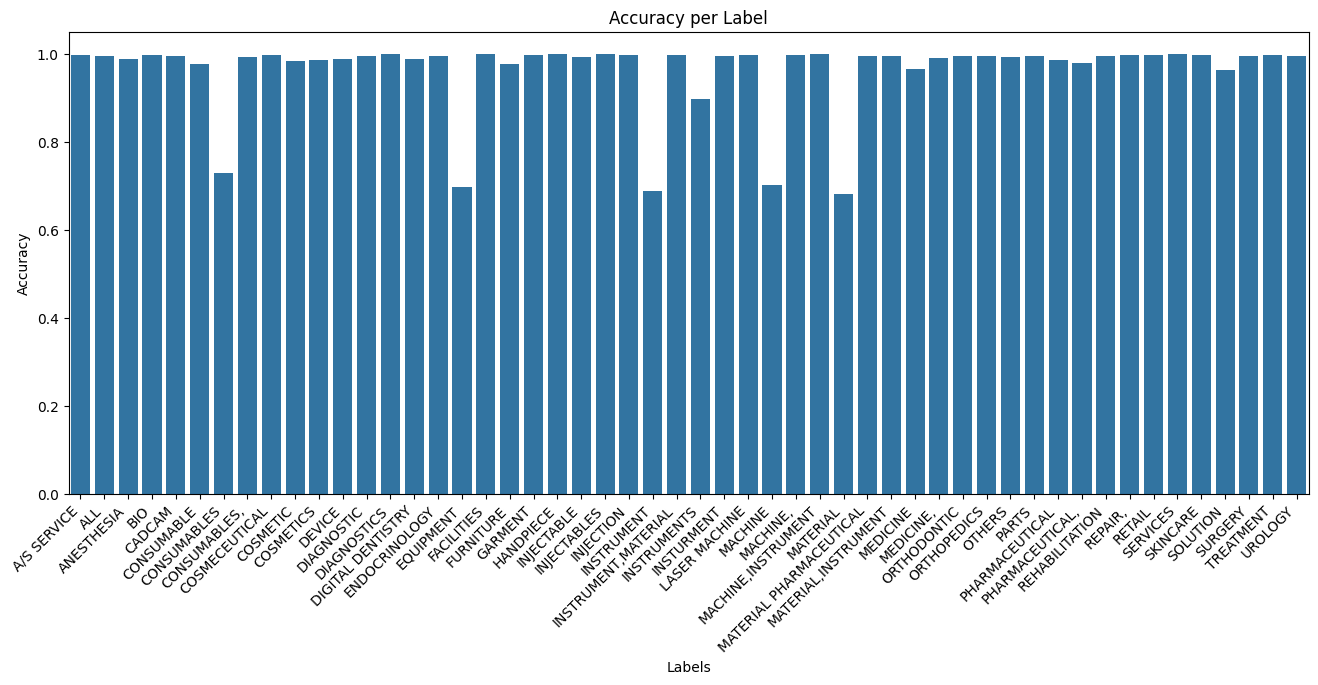

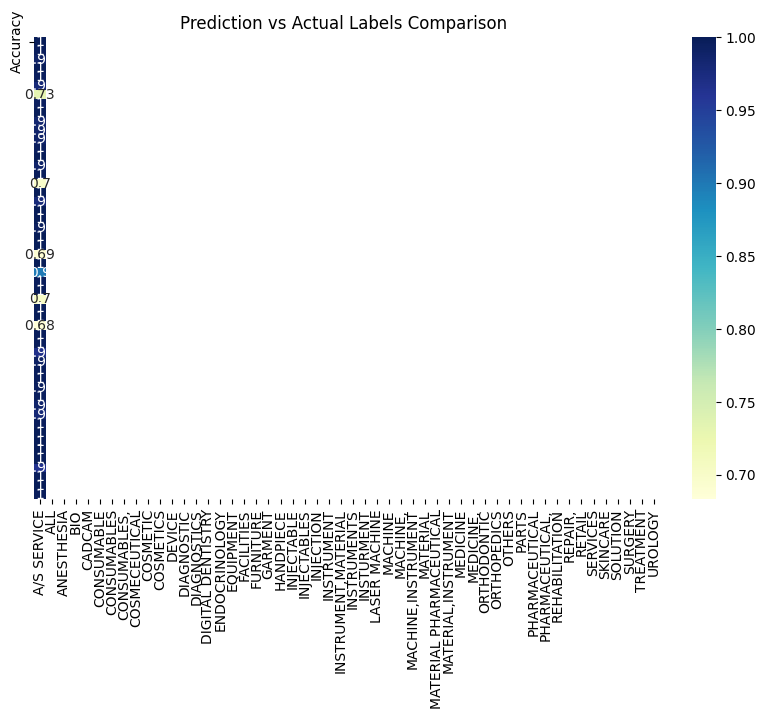

Sample 1: Predicted = ('CONSUMABLES',), Actual = ('CONSUMABLES',)
Sample 2: Predicted = ('INSTRUMENT', 'MACHINE', 'MATERIAL'), Actual = ('EQUIPMENT', 'MACHINE')
Sample 3: Predicted = ('CONSUMABLES', 'EQUIPMENT', 'INSTRUMENT'), Actual = ('CONSUMABLES', 'INSTRUMENT', 'MATERIAL', 'MEDICINE')
Sample 4: Predicted = ('CONSUMABLES',), Actual = ('CONSUMABLES',)
Sample 5: Predicted = ('INSTRUMENT', 'MACHINE', 'MATERIAL'), Actual = ('CONSUMABLES', 'EQUIPMENT', 'INSTRUMENT', 'MACHINE', 'MATERIAL')
Sample 6: Predicted = ('CONSUMABLES',), Actual = ('CONSUMABLES', 'EQUIPMENT', 'MATERIAL')
Sample 7: Predicted = ('CONSUMABLES', 'EQUIPMENT'), Actual = ('CONSUMABLES', 'EQUIPMENT')
Sample 8: Predicted = ('MACHINE',), Actual = ('MACHINE', 'SOLUTION')
Sample 9: Predicted = ('CONSUMABLES',), Actual = ('BIO', 'CONSUMABLES', 'MATERIAL', 'PHARMACEUTICAL')
Sample 10: Predicted = ('CONSUMABLES', 'EQUIPMENT', 'INSTRUMENT', 'MACHINE', 'MATERIAL'), Actual = ('CONSUMABLES', 'EQUIPMENT', 'INSTRUMENT', 'MACHINE', 'MAT

In [39]:
predictions = clf.predict(X_test_tfidf)

# 예측된 레이블을 원래 레이블로 복원
predicted_labels = mlb.inverse_transform(predictions)
actual_labels = mlb.inverse_transform(y_test)

# 각 레이블에 대해 실제 값과 예측값 비교하기
# 레이블별 예측된 값과 실제 값의 일치를 비교
label_set = mlb.classes_

# 각 레이블의 실제 값과 예측 값의 일치를 계산
accuracy_per_label = []
for i, label in enumerate(label_set):
    actual = [1 if label in actual_labels[j] else 0 for j in range(len(actual_labels))]
    predicted = [1 if label in predicted_labels[j] else 0 for j in range(len(predicted_labels))]
    accuracy = np.mean(np.array(actual) == np.array(predicted))
    accuracy_per_label.append(accuracy)

# 시각화: 각 레이블에 대한 예측 정확도
plt.figure(figsize=(16, 6))
sns.barplot(x=label_set, y=accuracy_per_label)
plt.xlabel('Labels')
plt.ylabel('Accuracy')
plt.title('Accuracy per Label')
plt.xticks(rotation=45, ha='right')
plt.show()

# 혼동 행렬처럼, 각 샘플에 대해 예측된 레이블과 실제 레이블을 비교
sample_comparison = []
for i in range(len(predicted_labels)):
    comparison = f"Sample {i+1}: Predicted = {predicted_labels[i]}, Actual = {actual_labels[i]}"
    sample_comparison.append(comparison)

# 시각화: 예측과 실제 비교 (각 샘플)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(np.array([accuracy_per_label]).T, annot=True, cmap="YlGnBu", xticklabels=label_set, yticklabels=["Accuracy"], cbar=True)
plt.title('Prediction vs Actual Labels Comparison')
plt.show()

# 예시 출력
for comparison in sample_comparison:
    print(comparison)

In [40]:
print(sg3_expl.Segment1.unique())
sg1_expl

['MEDICAL' 'AESTHETIC' 'OTHERS' 'VENERINARY' 'HOSPITAL' 'DENTAL'
 'VETERINARY' 'PROCUREMENT']


,Buyer,Segment1,Segment2,Segment3,Item
0,COSMETIC LASERS ONLY,MEDICAL,DERMATOLOGY,MACHINE,ALMA
1,COSMETIC LASERS ONLY,AESTHETIC,DERMATOLOGY,MACHINE,ALMA
2,COSMETIC LASERS ONLY,MEDICAL,DERMATOLOGY,MACHINE,CUTERA
3,COSMETIC LASERS ONLY,AESTHETIC,DERMATOLOGY,MACHINE,CUTERA
4,COSMETIC LASERS ONLY,MEDICAL,DERMATOLOGY,MACHINE,CYNERON
...,...,...,...,...,...
7983,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",ELECTRODE
7984,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",ELECTROSURGICAL PENCIL
7985,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",NEEDLE
7986,YIELD CENTER S.A.C.,MEDICAL,DERMATOLOGY,MACHINE,LASER


In [41]:
sg2_expl

,Buyer,Segment1,Segment2,Segment3,Item
0,COSMETIC LASERS ONLY,MEDICAL,DERMATOLOGY,MACHINE,ALMA
1,COSMETIC LASERS ONLY,AESTHETIC,DERMATOLOGY,MACHINE,ALMA
2,COSMETIC LASERS ONLY,MEDICAL,DERMATOLOGY,MACHINE,CUTERA
3,COSMETIC LASERS ONLY,AESTHETIC,DERMATOLOGY,MACHINE,CUTERA
4,COSMETIC LASERS ONLY,MEDICAL,DERMATOLOGY,MACHINE,CYNERON
...,...,...,...,...,...
28881,XODUS MEDICAL INC,MEDICAL,REHABILITATION,"EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",ELECTROSURGICAL PENCIL
28882,XODUS MEDICAL INC,MEDICAL,ORTHOPEDIC,"EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",NEEDLE
28883,XODUS MEDICAL INC,MEDICAL,REHABILITATION,"EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",NEEDLE
28884,YIELD CENTER S.A.C.,MEDICAL,DERMATOLOGY,MACHINE,LASER


In [42]:
print(sg3_expl.Segment3.unique())
sg3_expl

['MACHINE' 'MATERIAL' 'COSMETICS' 'SKINCARE' 'COSMECEUTICAL' 'COSMETIC'
 'CONSUMABLES' 'EQUIPMENT' 'SERVICES' 'RETAIL' 'INSTRUMENT'
 'PHARMACEUTICAL' 'PARTS' 'A/S SERVICE' 'INSTURMENT' 'CONSUMABLE'
 'FURNITURE' 'DEVICE' 'MEDICINE' 'SOLUTION' 'GARMENT' 'INJECTABLE'
 'TREATMENT' 'DIAGNOSTICS' 'DIAGNOSTIC' 'DIGITAL DENTISTRY' 'ANESTHESIA'
 'BIO' 'ALL' 'REPAIR' 'FACILITIES' 'MATERIAL PHARMACEUTICAL' 'ORTHOPEDICS'
 'ENDOCRINOLOGY' 'UROLOGY' 'REHABILITATION' 'SURGERY' 'OTHERS' 'INJECTION'
 'LASER MACHINE' 'INSTRUMENTS' 'CADCAM' 'INJECTABLES' 'ORTHODONTIC'
 'HANDPIECE']


,Buyer,Segment1,Segment2,Segment3,Item
0,COSMETIC LASERS ONLY,MEDICAL,DERMATOLOGY,MACHINE,ALMA
1,COSMETIC LASERS ONLY,AESTHETIC,DERMATOLOGY,MACHINE,ALMA
2,COSMETIC LASERS ONLY,MEDICAL,DERMATOLOGY,MACHINE,CUTERA
3,COSMETIC LASERS ONLY,AESTHETIC,DERMATOLOGY,MACHINE,CUTERA
4,COSMETIC LASERS ONLY,MEDICAL,DERMATOLOGY,MACHINE,CYNERON
...,...,...,...,...,...
93082,XODUS MEDICAL INC,MEDICAL,REHABILITATION,INSTRUMENT,NEEDLE
93083,XODUS MEDICAL INC,MEDICAL,REHABILITATION,MACHINE,NEEDLE
93084,XODUS MEDICAL INC,MEDICAL,REHABILITATION,CONSUMABLES,NEEDLE
93085,YIELD CENTER S.A.C.,MEDICAL,DERMATOLOGY,MACHINE,LASER


In [43]:
fil2 = pd.read_excel(r"D:\기업 프로젝트\딜리버리엠\한국공학대전달 DB_241119.xlsx")

dat2 = fil2[['Buyer', 'Segment1', 'Segment2', 'Segment3', 'Item']]
dat2 = dat2.map(lambda x: unidecode(x) if isinstance(x, str) else x)
dat2.dropna(inplace=True)

print(f'dat2.shape[0]: {dat2.shape[0]}')

dat2.loc[:, 'Item'] = dat2['Item'].str.replace(r'\n', ', ', flags=re.IGNORECASE, regex=True)
dat2.loc[:, 'Segment1'] = dat2['Segment1'].str.replace(r'\n', ', ', flags=re.IGNORECASE, regex=True)
dat2.loc[:, 'Segment2'] = dat2['Segment2'].str.replace(r'\n', ', ', flags=re.IGNORECASE, regex=True)
dat2.loc[:, 'Segment3'] = dat2['Segment3'].str.replace(r'\n', ', ', flags=re.IGNORECASE, regex=True)

dat2 = dat2[~dat2['Item'].str.contains(r'\.|such as|See all|This |which |These |They |Their | is | are |PROVIDES |in providing|PROVIDES A|specializes in', flags=re.IGNORECASE, na=False)] # 'Item', 'Segment1', 'Segment2', 'Segment3'
dat2 = dat2.map(lambda x: x.upper() if isinstance(x, str) else x) # 모든 열 대문자로
dat2 = dat2.apply(lambda col: col.str.strip()) # 좌우 공백 제거
dat2.reset_index(drop=True, inplace=True)

itm_exp2 = explode_df(dat2, 'Item')
sg1_exp2 = explode_df(itm_exp2, 'Segment1')
sg2_exp2 = explode_df(sg1_exp2, 'Segment2')
sg3_exp2 = explode_df(sg2_exp2, 'Segment3')

sg1_exp2

dat2.shape[0]: 4879


,Buyer,Segment1,Segment2,Segment3,Item
0,COSMETIC LASERS ONLY,MEDICAL,DERMATOLOGY,MACHINE,ALMA
1,COSMETIC LASERS ONLY,AESTHETIC,DERMATOLOGY,MACHINE,ALMA
2,COSMETIC LASERS ONLY,MEDICAL,DERMATOLOGY,MACHINE,CUTERA
3,COSMETIC LASERS ONLY,AESTHETIC,DERMATOLOGY,MACHINE,CUTERA
4,COSMETIC LASERS ONLY,MEDICAL,DERMATOLOGY,MACHINE,CYNERON
...,...,...,...,...,...
7987,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",ELECTRODE
7988,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",ELECTROSURGICAL PENCIL
7989,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",NEEDLE
7990,YIELD CENTER S.A.C.,MEDICAL,DERMATOLOGY,MACHINE,LASER


In [44]:
def make_test_df(df, column, og_df=sg3_expl):
    og_unique_values = set(og_df[column].unique())
    filtered_df = df[df[column].isin(og_unique_values)].reset_index(drop=True)
    return filtered_df

In [45]:
# sg3_exp2 = make_test_df(sg3_exp2, 'Segment1')
# sg3_exp2 = make_test_df(sg3_exp2, 'Segment2')
# sg3_exp2 = make_test_df(sg3_exp2, 'Segment3')

# sg3_exp2

In [46]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sg3_expl["Item"])  # TF-IDF 변환

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(sg3_expl["Segment1"]) # Segment1을 숫자 레이블로 변환

X_test = vectorizer.transform(sg3_exp2["Item"])  # TF-IDF 변환

y_test = mlb.transform(sg3_exp2["Segment1"]) # Segment1을 숫자 레이블로 변환

c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) [' '] will be ignored
  warnings.warn(


In [47]:
print(f'y.shape: {y.shape}')
y

y.shape: (93087, 17)


array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]])

In [48]:
model = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
model.fit(X, y)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

Accuracy: 0.8362569958427775


c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00     93075
           C       0.90      0.84      0.87     30947
           D       0.95      1.00      0.97     88042
           E       1.00      1.00      1.00     93027
           H       0.59      0.05      0.10      4603
           I       0.91      0.84      0.87     31451
           L       0.95      1.00      0.97     88110
           M       0.82      0.73      0.77     26421
           N       0.92      0.95      0.94     62068
           O       0.00      0.00      0.00        82
           P       0.00      0.00      0.00        67
           R       0.80      0.03      0.05       463
           S       0.59      0.05      0.10      4603
           T       0.90      0.94      0.92     66312
           U       0.00      0.00      0.00         1
           V       0.50      0.01      0.01       445
           Y       0.50      0.01      0.01       443

  

c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


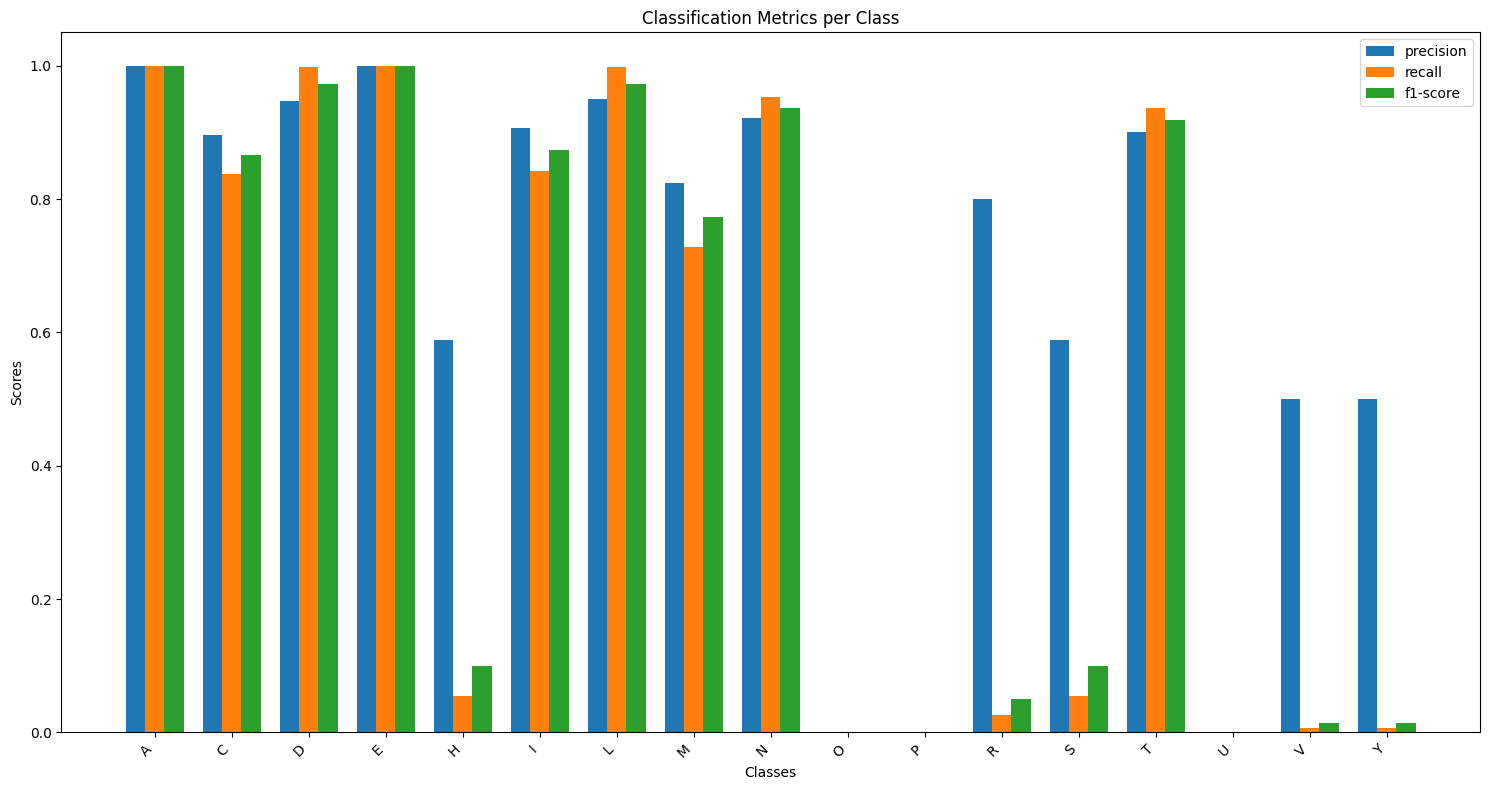

In [49]:
report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 클래스별 Precision, Recall, F1-Score 시각화
metrics = ['precision', 'recall', 'f1-score']
report_df = report_df.iloc[:-4]  # accuracy, macro avg, weighted avg 제거

plt.figure(figsize=(15, 8))
for i, metric in enumerate(metrics):
    plt.bar([x + i * 0.25 for x in range(len(report_df.index))], report_df[metric], width=0.25, label=metric)

plt.xticks([x + 0.25 for x in range(len(report_df.index))], report_df.index, rotation=45, ha='right')
plt.title('Classification Metrics per Class')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sg3_expl["Item"])  # TF-IDF 변환

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(sg3_expl["Segment2"]) # Segment2을 숫자 레이블로 변환

X_test = vectorizer.transform(sg3_exp2["Item"])  # TF-IDF 변환

y_test = mlb.transform(sg3_exp2["Segment2"]) # Segment2을 숫자 레이블로 변환

model = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
model.fit(X, y)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

Accuracy: 0.02813376158812345


c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

                   0.78      0.06      0.10      9408
           &       0.00      0.00      0.00       127
           (       0.00      0.00      0.00        19
           )       0.00      0.00      0.00        19
           -       0.00      0.00      0.00        36
           .       0.00      0.00      0.00        36
           A       0.68      0.96      0.79     61211
           B       0.85      0.02      0.04      6777
           C       0.58      0.28      0.38     37330
           D       0.64      0.26      0.37     36654
           E       0.69      0.98      0.81     62241
           F       0.00      0.00      0.00       998
           G       0.75      0.29      0.42     37738
           H       0.78      0.05      0.09     20898
           I       0.72      0.95      0.82     61697
           J       0.00      0.00      0.00        22
           K       0.00      0.00      0.00        82
   

c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


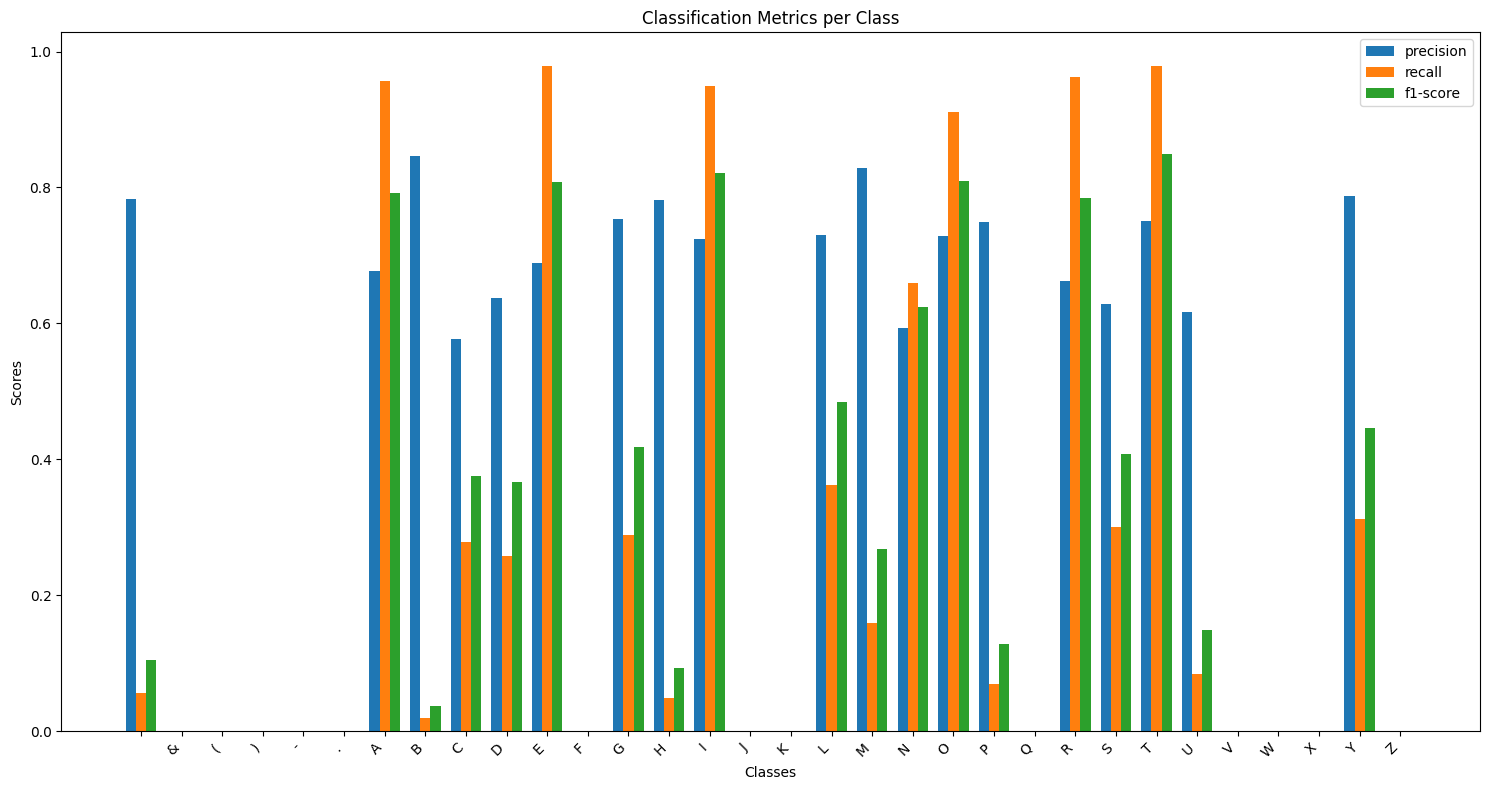

In [51]:
report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 클래스별 Precision, Recall, F1-Score 시각화
metrics = ['precision', 'recall', 'f1-score']
report_df = report_df.iloc[:-4]  # accuracy, macro avg, weighted avg 제거

plt.figure(figsize=(15, 8))
for i, metric in enumerate(metrics):
    plt.bar([x + i * 0.25 for x in range(len(report_df.index))], report_df[metric], width=0.25, label=metric)

plt.xticks([x + 0.25 for x in range(len(report_df.index))], report_df.index, rotation=45, ha='right')
plt.title('Classification Metrics per Class')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

Accuracy: 0.013588853917134847


c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

                   0.00      0.00      0.00       738
           /       0.00      0.00      0.00         2
           A       0.59      0.73      0.65     49163
           B       0.76      0.05      0.09     21722
           C       0.64      0.24      0.34     38492
           D       0.00      0.00      0.00      1970
           E       0.99      1.00      0.99     91747
           F       0.00      0.00      0.00      1005
           G       0.00      0.00      0.00       818
           H       0.67      0.02      0.04     15322
           I       0.77      1.00      0.87     71347
           J       0.00      0.00      0.00       312
           K       0.00      0.00      0.00       115
           L       0.66      0.11      0.19     36226
           M       0.95      1.00      0.97     88419
           N       0.85      1.00      0.92     78903
           O       0.75      0.09      0.16     23640
   

c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


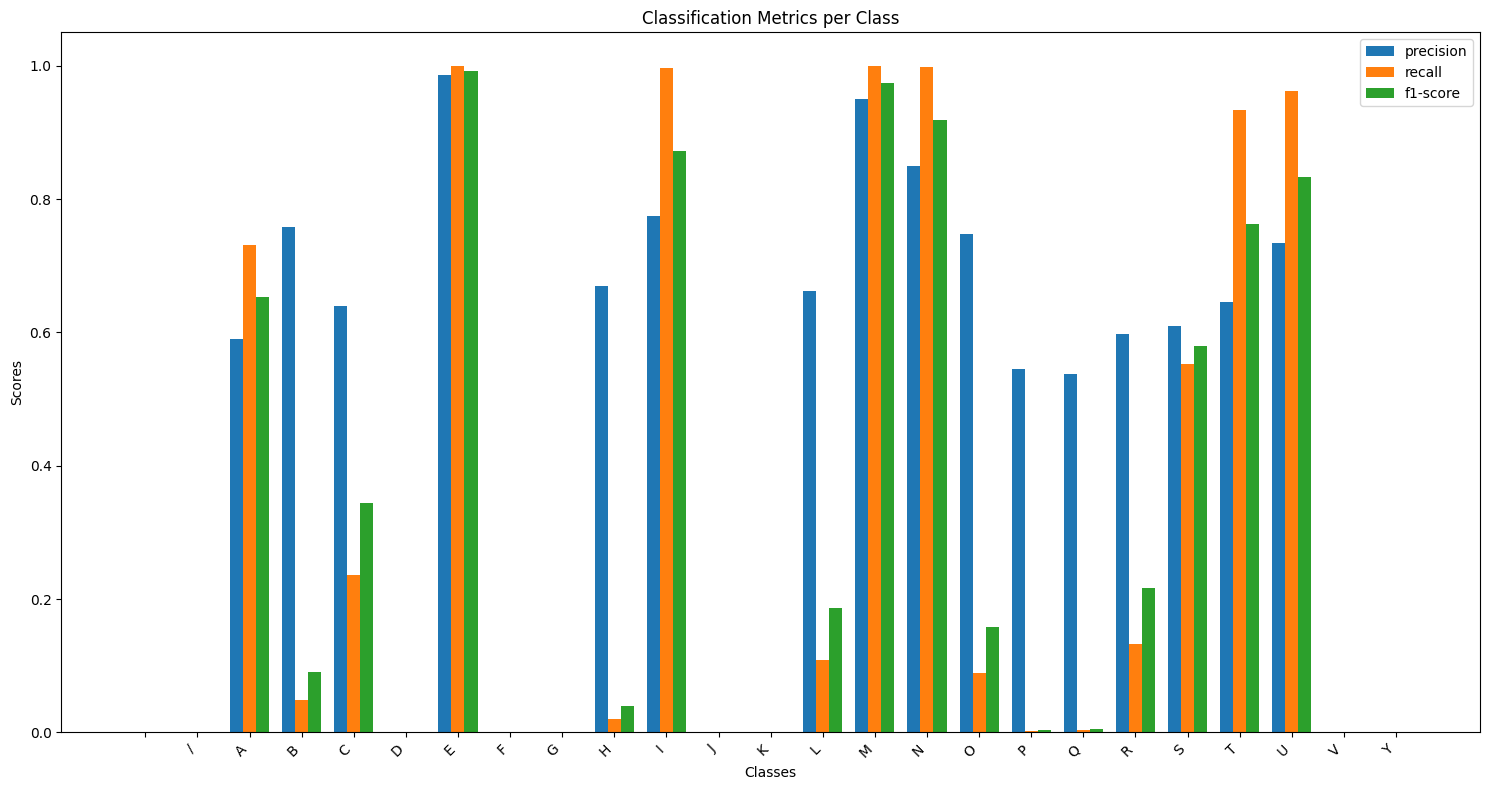

In [52]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sg3_expl["Item"])  # TF-IDF 변환

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(sg3_expl["Segment3"]) # Segment3을 숫자 레이블로 변환

X_test = vectorizer.transform(sg3_exp2["Item"])  # TF-IDF 변환

y_test = mlb.transform(sg3_exp2["Segment3"]) # Segment3을 숫자 레이블로 변환

model = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
model.fit(X, y)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 클래스별 Precision, Recall, F1-Score 시각화
metrics = ['precision', 'recall', 'f1-score']
report_df = report_df.iloc[:-4]  # accuracy, macro avg, weighted avg 제거

plt.figure(figsize=(15, 8))
for i, metric in enumerate(metrics):
    plt.bar([x + i * 0.25 for x in range(len(report_df.index))], report_df[metric], width=0.25, label=metric)

plt.xticks([x + 0.25 for x in range(len(report_df.index))], report_df.index, rotation=45, ha='right')
plt.title('Classification Metrics per Class')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

### 데이터프레임에 예측 결과 저장해서 보여주기

c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label 5 is present in all training examples.
  warnings.warn(


Accuracy: 0.7375178316690443
Classification Report:
               precision    recall  f1-score   support

                   0.90      0.42      0.57       200
           ,       0.90      0.42      0.57       200
           A       1.00      1.00      1.00      1401
           C       0.86      0.96      0.91       961
           D       0.99      1.00      0.99      1384
           E       1.00      1.00      1.00      1402
           H       0.88      0.49      0.63       169
           I       0.86      0.96      0.91       969
           L       0.99      1.00      0.99      1385
           M       0.86      0.96      0.90       953
           N       0.87      0.64      0.74       481
           O       0.00      0.00      0.00         6
           P       0.00      0.00      0.00         5
           R       0.00      0.00      0.00        33
           S       0.88      0.49      0.63       168
           T       0.87      0.83      0.85       625
           U       0.00     

c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

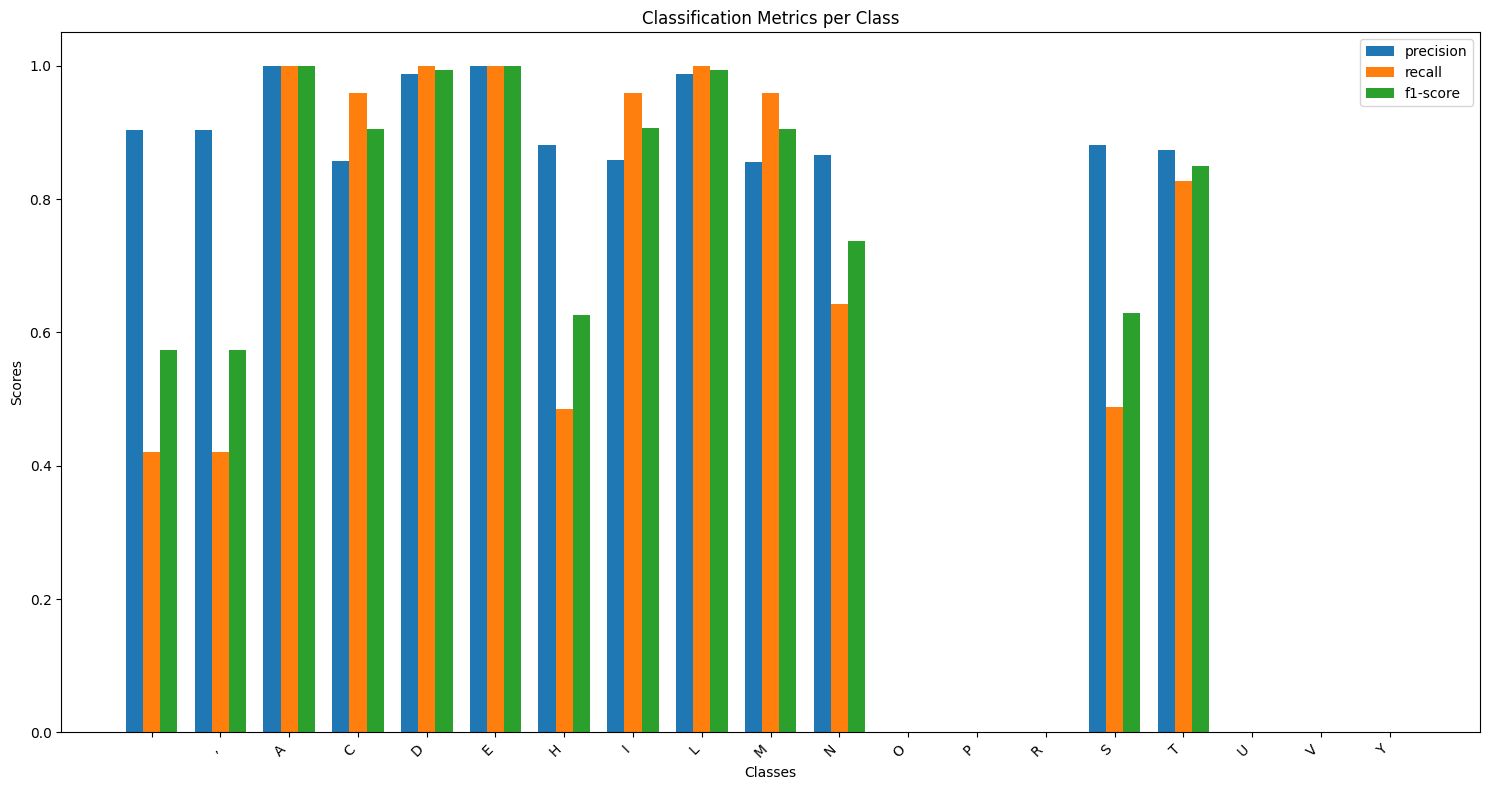

In [53]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(itm_exp2["Item"])  # TF-IDF 변환

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(itm_exp2["Segment1"]) # Segment1을 숫자 레이블로 변환

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#, stratify=y)

model = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
model.fit(X, y)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 클래스별 Precision, Recall, F1-Score 시각화
metrics = ['precision', 'recall', 'f1-score']
report_df = report_df.iloc[:-4]  # accuracy, macro avg, weighted avg 제거

plt.figure(figsize=(15, 8))
for i, metric in enumerate(metrics):
    plt.bar([x + i * 0.25 for x in range(len(report_df.index))], report_df[metric], width=0.25, label=metric)

plt.xticks([x + 0.25 for x in range(len(report_df.index))], report_df.index, rotation=45, ha='right')
plt.title('Classification Metrics per Class')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

Accuracy: 0.1847360912981455
Classification Report:
               precision    recall  f1-score   support

                   0.79      0.99      0.88      1007
           &       0.00      0.00      0.00        12
           (       0.00      0.00      0.00         4
           )       0.00      0.00      0.00         4
           ,       0.79      0.98      0.87       964
           -       0.00      0.00      0.00         3
           .       0.00      0.00      0.00         2
           A       0.96      1.00      0.98      1352
           B       0.80      0.36      0.50       413
           C       0.78      0.96      0.86       914
           D       0.78      0.94      0.85       927
           E       0.84      1.00      0.91      1149
           F       0.00      0.00      0.00        36
           G       0.78      0.98      0.87       999
           H       0.77      0.98      0.86       892
           I       0.87      0.98      0.93      1156
           J       0.00     

c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


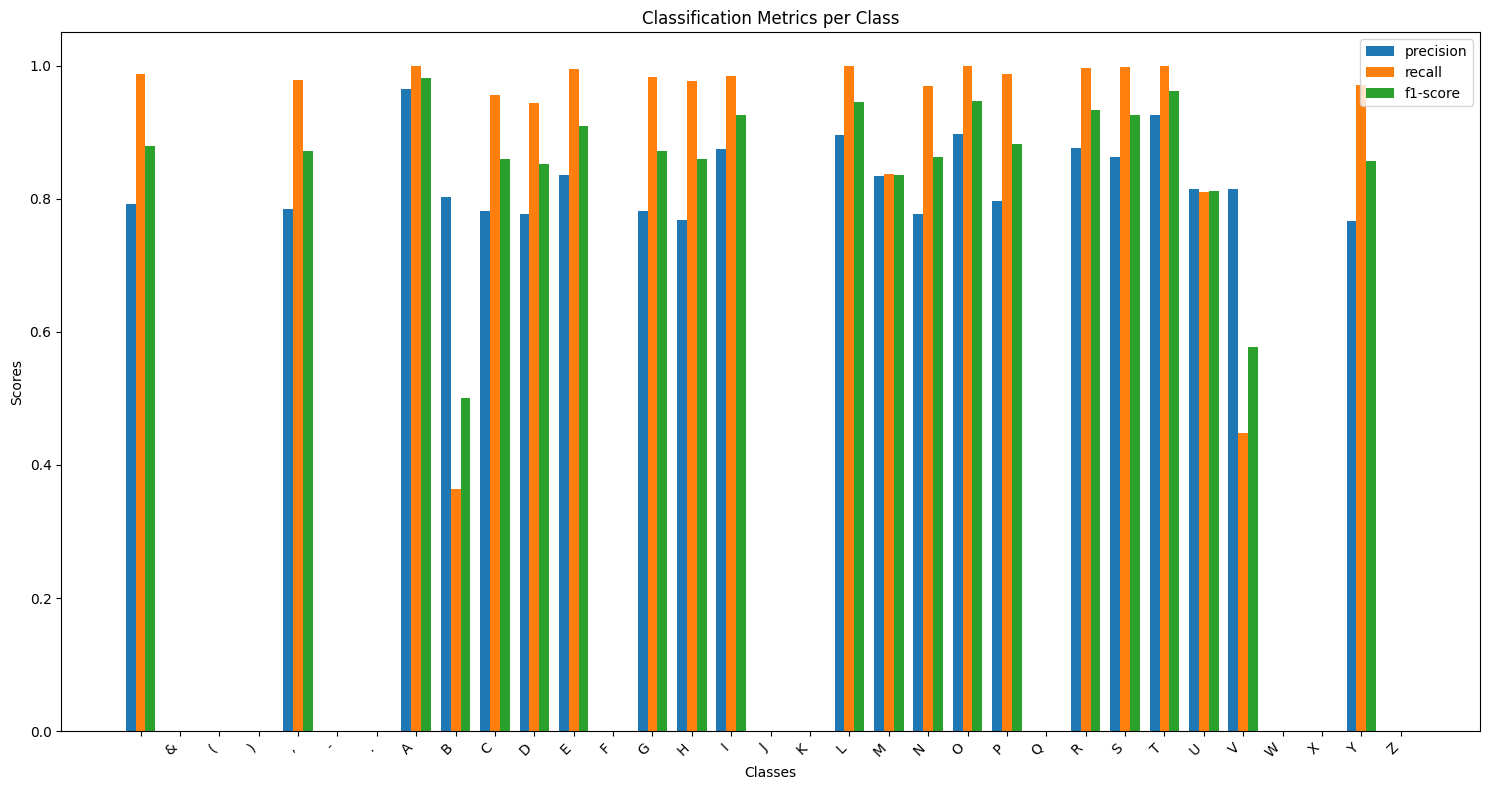

In [54]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(itm_exp2["Segment2"]) # Segment1을 숫자 레이블로 변환

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#, stratify=y)

model = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
model.fit(X, y)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 클래스별 Precision, Recall, F1-Score 시각화
metrics = ['precision', 'recall', 'f1-score']
report_df = report_df.iloc[:-4]  # accuracy, macro avg, weighted avg 제거

plt.figure(figsize=(15, 8))
for i, metric in enumerate(metrics):
    plt.bar([x + i * 0.25 for x in range(len(report_df.index))], report_df[metric], width=0.25, label=metric)

plt.xticks([x + 0.25 for x in range(len(report_df.index))], report_df.index, rotation=45, ha='right')
plt.title('Classification Metrics per Class')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

Accuracy: 0.38516405135520687
Classification Report:
               precision    recall  f1-score   support

                   0.82      0.98      0.90      1084
           ,       0.82      0.98      0.90      1084
           /       0.00      0.00      0.00         1
           A       0.96      1.00      0.98      1343
           B       0.82      0.97      0.89      1008
           C       0.94      1.00      0.97      1310
           D       0.00      0.00      0.00        96
           E       1.00      1.00      1.00      1400
           F       0.00      0.00      0.00        29
           G       0.00      0.00      0.00        22
           H       0.89      0.67      0.76       566
           I       0.86      1.00      0.93      1176
           J       0.91      0.32      0.48        31
           K       1.00      0.83      0.91        12
           L       0.89      0.99      0.93      1214
           M       0.99      1.00      0.99      1382
           N       0.99    

c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


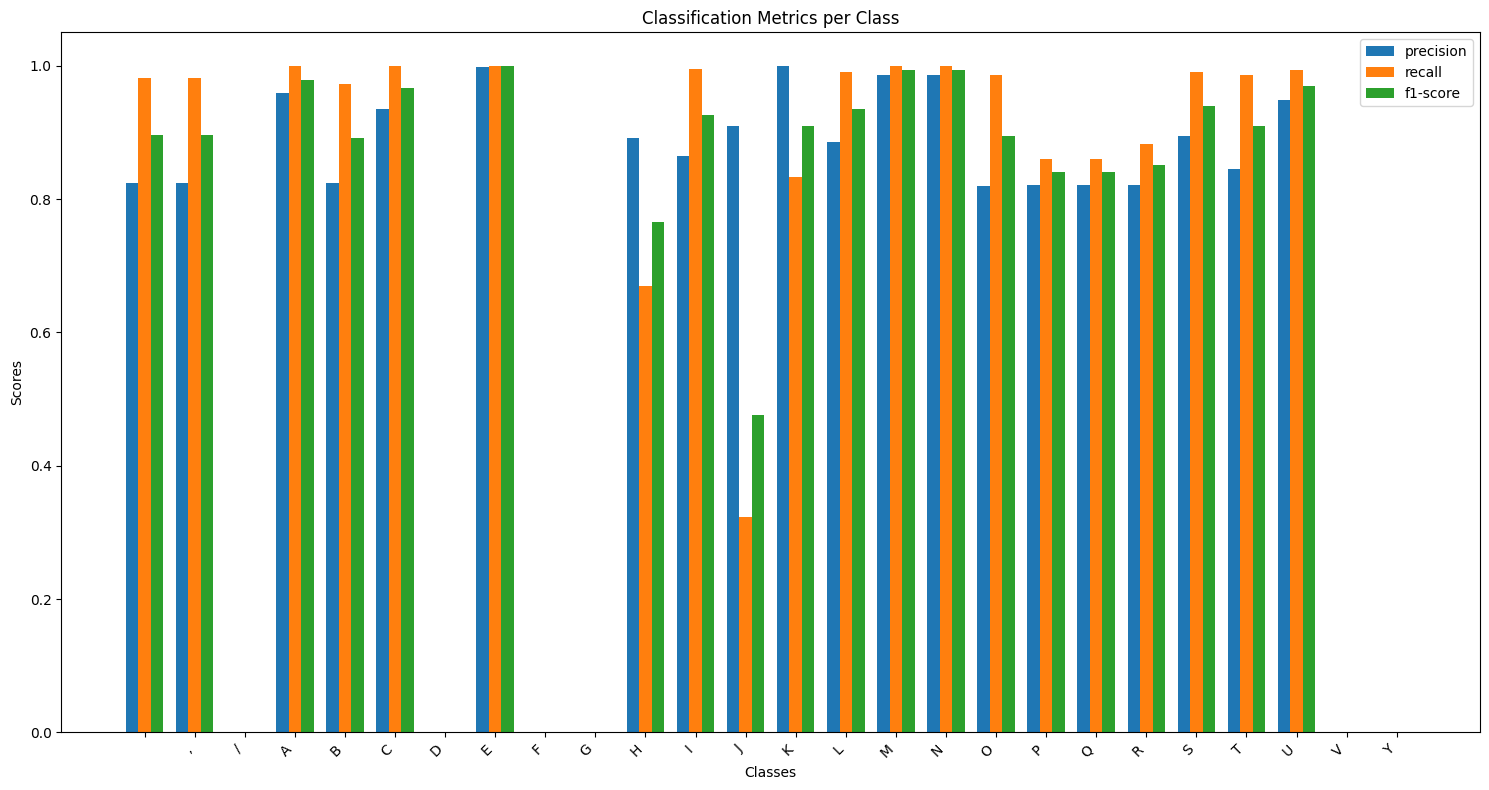

In [55]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(itm_exp2["Segment3"]) # Segment1을 숫자 레이블로 변환

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#, stratify=y)

model = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
model.fit(X, y)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 클래스별 Precision, Recall, F1-Score 시각화
metrics = ['precision', 'recall', 'f1-score']
report_df = report_df.iloc[:-4]  # accuracy, macro avg, weighted avg 제거

plt.figure(figsize=(15, 8))
for i, metric in enumerate(metrics):
    plt.bar([x + i * 0.25 for x in range(len(report_df.index))], report_df[metric], width=0.25, label=metric)

plt.xticks([x + 0.25 for x in range(len(report_df.index))], report_df.index, rotation=45, ha='right')
plt.title('Classification Metrics per Class')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
mlb.classes_

array([' ', ',', '/', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'Y'],
      dtype=object)

### 음

c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) [' ', ',', 'A', 'C', 'D', 'E', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y'] will be ignored
  warnings.warn(


Accuracy: 0.010128388017118403
Classification Report:
               precision    recall  f1-score   support

                   0.00      0.00      0.00         0
   AESTHETIC       0.00      0.00      0.00         0
      DENTAL       0.00      0.00      0.00         0
    HOSPITAL       0.00      0.00      0.00         0
     MEDICAL       0.00      0.00      0.00         0
      OTHERS       0.00      0.00      0.00         0
 PROCUREMENT       0.00      0.00      0.00         0
  VENERINARY       0.00      0.00      0.00         0
  VETERINARY       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0
 samples avg       0.00      0.00      0.00         0



c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

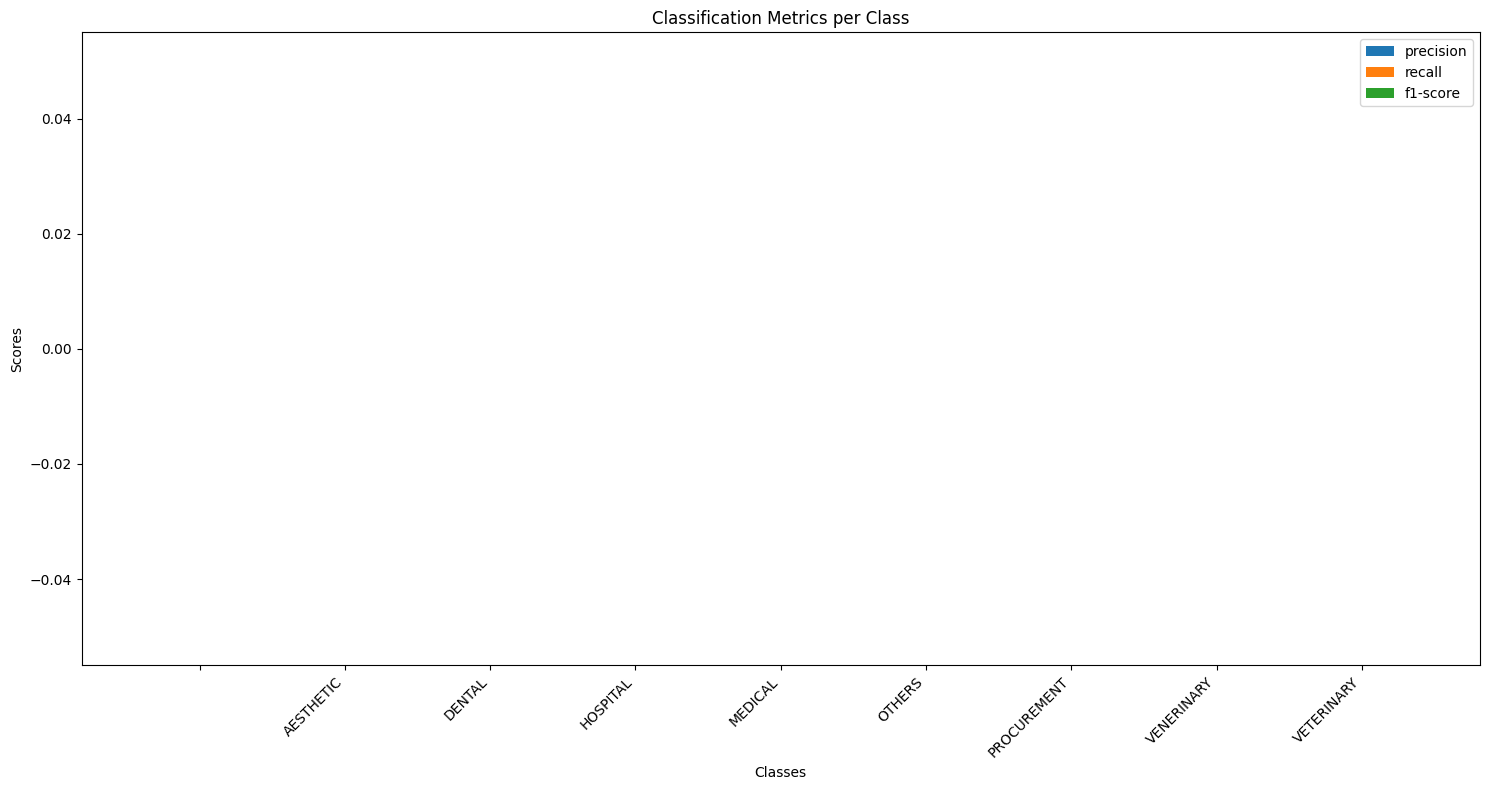

In [57]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(itm_expl["Item"])  # TF-IDF 변환

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(itm_expl["Segment1"]) # Segment1을 숫자 레이블로 변환

X_test = vectorizer.transform(itm_exp2["Item"])  # TF-IDF 변환

y_test = mlb.transform(itm_exp2["Segment1"]) # Segment1을 숫자 레이블로 변환

model = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
model.fit(X, y)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 클래스별 Precision, Recall, F1-Score 시각화
metrics = ['precision', 'recall', 'f1-score']
report_df = report_df.iloc[:-4]  # accuracy, macro avg, weighted avg 제거

plt.figure(figsize=(15, 8))
for i, metric in enumerate(metrics):
    plt.bar([x + i * 0.25 for x in range(len(report_df.index))], report_df[metric], width=0.25, label=metric)

plt.xticks([x + 0.25 for x in range(len(report_df.index))], report_df.index, rotation=45, ha='right')
plt.title('Classification Metrics per Class')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
itm_expl

,Buyer,Segment1,Segment2,Segment3,Item
0,COSMETIC LASERS ONLY,"[MEDICAL, AESTHETIC]",[DERMATOLOGY],[MACHINE],ALMA
1,COSMETIC LASERS ONLY,"[MEDICAL, AESTHETIC]",[DERMATOLOGY],[MACHINE],CUTERA
2,COSMETIC LASERS ONLY,"[MEDICAL, AESTHETIC]",[DERMATOLOGY],[MACHINE],CYNERON
3,COSMETIC LASERS ONLY,"[MEDICAL, AESTHETIC]",[DERMATOLOGY],[MACHINE],LUMENIS
4,(AFTER INKED COLOMBIA) SAS,[AESTHETIC],[DERMATOLOGY],"[MATERIAL, COSMETICS]",TATOO CREAM
...,...,...,...,...,...
7001,WINMED,[MEDICAL],[HOSPITAL],[EQUIPMENT],AIR PILLAR
7002,XODUS MEDICAL INC,[MEDICAL],"[ORTHOPEDIC, REHABILITATION]","[EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES]",ELECTRODE
7003,XODUS MEDICAL INC,[MEDICAL],"[ORTHOPEDIC, REHABILITATION]","[EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES]",ELECTROSURGICAL PENCIL
7004,XODUS MEDICAL INC,[MEDICAL],"[ORTHOPEDIC, REHABILITATION]","[EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES]",NEEDLE


In [59]:
itm_exp2

,Buyer,Segment1,Segment2,Segment3,Item
0,COSMETIC LASERS ONLY,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,ALMA
1,COSMETIC LASERS ONLY,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,CUTERA
2,COSMETIC LASERS ONLY,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,CYNERON
3,COSMETIC LASERS ONLY,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,LUMENIS
4,(AFTER INKED COLOMBIA) SAS,AESTHETIC,DERMATOLOGY,"MATERIAL, COSMETICS",TATOO CREAM
...,...,...,...,...,...
7005,WINMED,MEDICAL,HOSPITAL,EQUIPMENT,AIR PILLAR
7006,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",ELECTRODE
7007,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",ELECTROSURGICAL PENCIL
7008,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES",NEEDLE


In [60]:
print(len(itm_exp2.Segment1.unique()))
itm_exp2.Segment1.unique()

17


array(['MEDICAL, AESTHETIC', 'AESTHETIC', 'MEDICAL', 'OTHERS',
       'MEDICAL, VENERINARY', 'MEDICAL, HOSPITAL', 'DENTAL',
       'DENTAL, MEDICAL', 'MEDICAL, AESTHETIC, DENTAL', ', MEDICAL',
       'VETERINARY', 'MEDICAL, PROCUREMENT', 'DENTAL, AESTHETIC',
       'AESTHETIC, MEDICAL', 'MEDICAL, DENTAL', 'HEALTHCARE',
       'PERSONAL SERVICES'], dtype=object)

In [61]:
y_test[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) [' ', '&', '(', ')', '-', '.', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] will be ignored
  warnings.warn(


Accuracy: 0.23067047075606276
Classification Report:
                                       precision    recall  f1-score   support

                                   ,       0.00      0.00      0.00      4740
                           AESTHETIC       0.00      0.00      0.00         0
                      AESTHETIC SHOP       0.00      0.00      0.00         0
     AESTHETICS,UROLOGY,GYNECOLOGIST       0.00      0.00      0.00         0
                     AI IN RADIOLOGY       0.00      0.00      0.00         0
                    AIRLINE CATERING       0.00      0.00      0.00         0
                   AIRWAY MANAGEMENT       0.00      0.00      0.00         0
                                 ALL       0.00      0.00      0.00         0
                          ANESTHESIA       0.00      0.00      0.00         0
                      ANESTHESIOLOGY       0.00      0.00      0.00         0
                          ANESTHETIC       0.00      0.00      0.00         0
         

c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

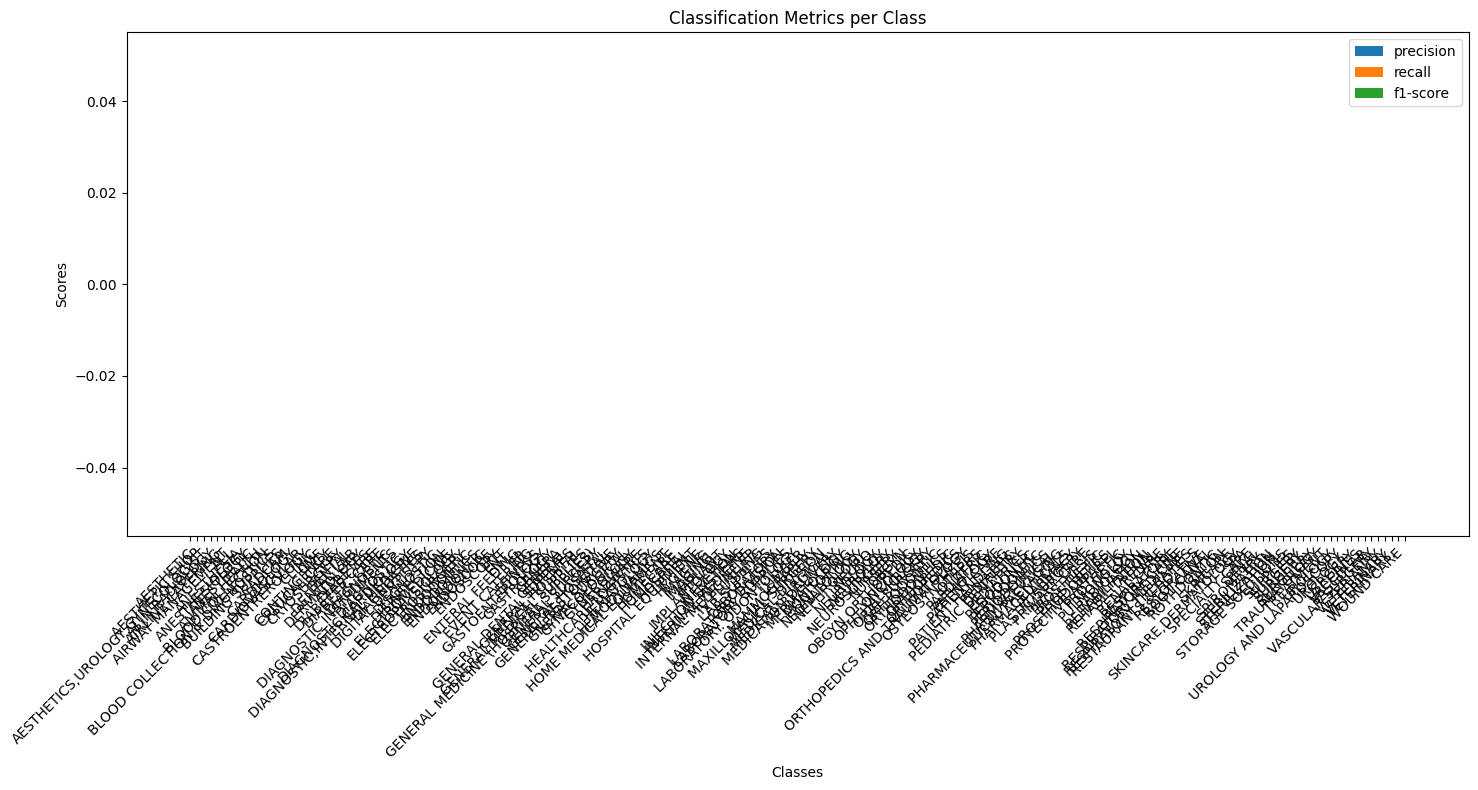

In [62]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(itm_expl["Item"])  # TF-IDF 변환

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(itm_expl["Segment2"]) # Segment2을 숫자 레이블로 변환

X_test = vectorizer.transform(itm_exp2["Item"])  # TF-IDF 변환

y_test = mlb.transform(itm_exp2["Segment2"]) # Segment2을 숫자 레이블로 변환

model = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
model.fit(X, y)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 클래스별 Precision, Recall, F1-Score 시각화
metrics = ['precision', 'recall', 'f1-score']
report_df = report_df.iloc[:-4]  # accuracy, macro avg, weighted avg 제거

plt.figure(figsize=(15, 8))
for i, metric in enumerate(metrics):
    plt.bar([x + i * 0.25 for x in range(len(report_df.index))], report_df[metric], width=0.25, label=metric)

plt.xticks([x + 0.25 for x in range(len(report_df.index))], report_df.index, rotation=45, ha='right')
plt.title('Classification Metrics per Class')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) [' ', ',', '/', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'Y'] will be ignored
  warnings.warn(


Accuracy: 0.009985734664764621
Classification Report:
                          precision    recall  f1-score   support

            A/S SERVICE       0.00      0.00      0.00         0
                    ALL       0.00      0.00      0.00         0
             ANESTHESIA       0.00      0.00      0.00         0
                    BIO       0.00      0.00      0.00         0
                 CADCAM       0.00      0.00      0.00         0
             CONSUMABLE       0.00      0.00      0.00         0
            CONSUMABLES       0.00      0.00      0.00         0
           CONSUMABLES,       0.00      0.00      0.00         0
          COSMECEUTICAL       0.00      0.00      0.00         0
               COSMETIC       0.00      0.00      0.00         0
              COSMETICS       0.00      0.00      0.00         0
                 DEVICE       0.00      0.00      0.00         0
             DIAGNOSTIC       0.00      0.00      0.00         0
            DIAGNOSTICS       0.00

c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hwjh2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

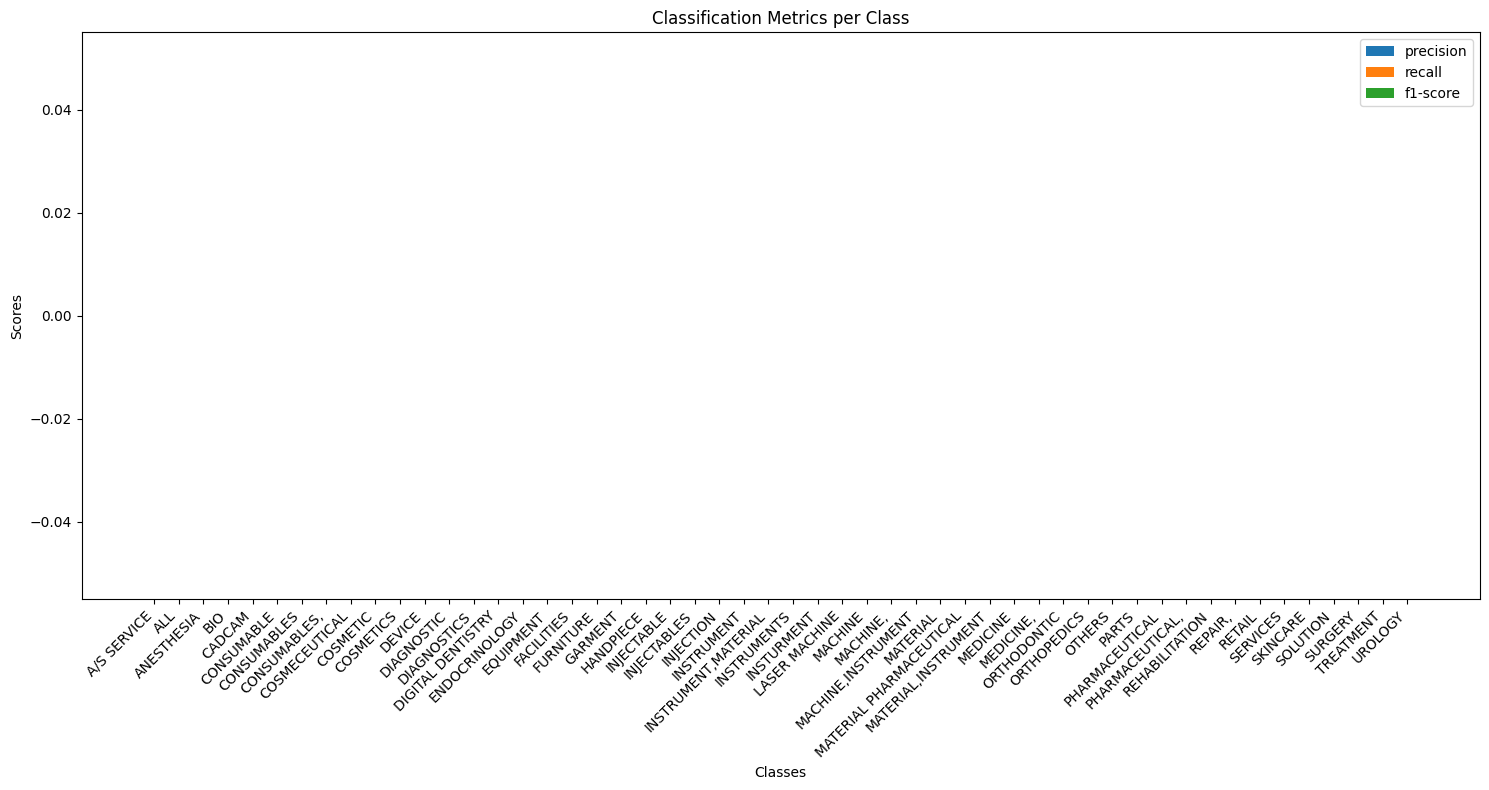

In [63]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(itm_expl["Item"])  # TF-IDF 변환

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(itm_expl["Segment3"]) # Segment3을 숫자 레이블로 변환

X_test = vectorizer.transform(itm_exp2["Item"])  # TF-IDF 변환

y_test = mlb.transform(itm_exp2["Segment3"]) # Segment3을 숫자 레이블로 변환

model = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
model.fit(X, y)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 클래스별 Precision, Recall, F1-Score 시각화
metrics = ['precision', 'recall', 'f1-score']
report_df = report_df.iloc[:-4]  # accuracy, macro avg, weighted avg 제거

plt.figure(figsize=(15, 8))
for i, metric in enumerate(metrics):
    plt.bar([x + i * 0.25 for x in range(len(report_df.index))], report_df[metric], width=0.25, label=metric)

plt.xticks([x + 0.25 for x in range(len(report_df.index))], report_df.index, rotation=45, ha='right')
plt.title('Classification Metrics per Class')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()